In [1]:
from pymongo import MongoClient 
import re
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Flatten, GlobalAveragePooling1D, Embedding, Lambda

2024-05-03 17:24:59.921756: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1. Database Connection

In [2]:
uri = 'mongodb://localhost:27017/'
client = MongoClient(uri)

In [3]:
client.list_database_names()

['Lab1', 'admin', 'config', 'local']

# 2. Import articles

In [7]:

import nltk
from nltk.tokenize import sent_tokenize, WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.stem import ISRIStemmer, WordNetLemmatizer
import re
import string 
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')


db = client["Lab1"]
article_collection = db["articles"]
articles = article_collection.find().limit (30)

[nltk_data] Downloading package punkt to
[nltk_data]     /home/ayoubbakkali/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ayoubbakkali/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/ayoubbakkali/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ayoubbakkali/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# (LAB1)

In [8]:
def text_cleaning(collection, pattern):
    article_cleaning = []
    for article in collection:
        try:
            content_article = article["content"]
            if content_article and len(content_article) > 0:
                # Removing 
                cleaned_content = re.sub(pattern, '', content_article[0])
                article_cleaning.append(cleaned_content)    
        except KeyError:
            # Handle the case where 'content' key is not found in the article
            print("Key 'content' not found in article:", article)
        except Exception as e:
            # Handle other potential errors
            print("Error processing article:", e)
    return article_cleaning 

def sentences_tokenize(articles):
    output = []
    for article in articles:
        output.append(sent_tokenize(article))
    return output


# Pre-tokenize stopwords
stop_words = set(stopwords.words('arabic'))
tokenizer = WordPunctTokenizer()

def removing_stopwords(pip):
    sentences_without_stopwords = []
    for article_sentences in pip:
        content_without_stopwords = []
        for sentence in article_sentences:
            words = tokenizer.tokenize(sentence)
            words = [w for w in words if w not in stop_words]
            content_without_stopwords.append(words)
        sentences_without_stopwords.append(content_without_stopwords)
    return sentences_without_stopwords

In [9]:
pattern = r'[^\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF\uFB50-\uFDFF\uFE70-\uFEFF\s.,;:!?؟]'
pip1 = text_cleaning(articles,pattern)
pip2 = sentences_tokenize(pip1)
pip3 = removing_stopwords(pip2)


In [10]:
pip2[0]

['أخبارعمليات نوعية للقسام توقع  قتيلا من جنود الاحتلال بخان يونس  مدة الفيديو     :آخر تحديث: : م بتوقيت مكة المكرمةكبدت كتائب عز الدين القسام\xa0الجناح العسكري لحركة المقاومة الإسلامية حماس قوات الاحتلال الإسرائيلي  قتيلا وعدة إصابات في عمليات نوعية نفذتها اليوم السبت في محور خان يونس بقطاع غزة.',
 'وقالت كتائب القسام في بيان إن مقاتليها قتلوا  جنود إسرائيليين، وأصابوا آخرين، في منطقة الزنة شرقي خان يونس، موضحة أنها استهدفت  دبابات ميركافا بقذائف الياسين ، مشيرة إلى أنه فور تقدم قوات الإنقاذ إلى المكان ووصولها إلى وسط حقل ألغام أُعد مسبقا، استُهدفت بتفجير  عبوات مضادة للأفراد.',
 'وأوضح بيان القسام أن المواجهات لا تزال مستمرة في منطقة الزنة، شرقي خان يونس.',
 'كما أعلنت كتائب القسام قتل  جنود إسرائيليين من مسافة صفر وإصابة آخرين وتدمير ناقلة جند بمنطقة حي الأمل غرب خان يونس، فضلا عن استهداف دبابة إسرائيلية أخرى بقذيفة الياسين  وقوة راجلة بعبوة وإيقاعها بين قتيل وجريح في خان يونس.',
 'وأفاد مراسل الجزيرة بهبوط  طائرات مروحية للجيش الإسرائيلي لنقل جرحى من جنود الاحتلال شرقي خان يونس\nم

# 3. Applying One hot encodding, bag of words, TF-IDF

### 3.1 One hot encodding

In [8]:
import pandas as pd

def on_hot_encoding(articles):
    # Step 1: Create a set of unique words
    unique_words = set(word for article in articles for sentence in article for word in sentence)
    
    # Step 2: Create a dictionary to map words to indices
    word_to_index = {word: i for i, word in enumerate(unique_words)}
    
    # Initialize an empty list to store the one-hot encoded vectors
    encoded_vectors = []
    
    # Iterate through each article, sentence, and word to encode
    for article in articles:
        for sentence in article:
            for word in sentence:
                # Initialize a vector with zeros
                vector = [0] * len(unique_words)
                # Set the index corresponding to the word to 1
                vector[word_to_index[word]] = 1
                # Append the vector to the list
                encoded_vectors.append(vector)
    
    # Convert the list of lists to a DataFrame
    encoded_df = pd.DataFrame(encoded_vectors)
    
    return encoded_df

In [9]:
encoded_df = on_hot_encoding(pip3)
encoded_df

,0,1,2,3,4,5,6,7,8,9,...,4302,4303,4304,4305,4306,4307,4308,4309,4310,4311
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11791,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11792,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11793,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11794,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
for column in encoded_df.columns:
    # Get the indices where the value is 1 in each column
    indices = encoded_df.index[encoded_df[column] == 1].tolist()
    # Print the column name and the corresponding row indices where the value is 1
    print(f"{column}: {indices}")

0: [4353]
1: [4886]
2: [4818]
3: [10146]
4: [3947]
5: [4826]
6: [1395]
7: [11632]
8: [5454, 5480, 5482]
9: [7253, 7916]
10: [9380]
11: [3842]
12: [1527, 11489]
13: [5983]
14: [5866, 7256, 7919]
15: [3614, 9564]
16: [3733, 4176]
17: [4092, 4156]
18: [8411]
19: [4720]
20: [5094, 7082, 8905, 9527, 9628, 9730, 9975, 10070, 10115, 10127, 11343, 11364, 11426, 11432, 11441]
21: [5077]
22: [7542]
23: [4132]
24: [11721]
25: [116, 2348, 5146, 6631, 6737]
26: [64]
27: [4895]
28: [2046, 2066, 5873, 5893, 6003]
29: [9811]
30: [976, 5133, 10227]
31: [3639]
32: [10129]
33: [3533, 7775]
34: [668]
35: [11667]
36: [7844]
37: [3353]
38: [3882]
39: [4260, 9045]
40: [8705]
41: [817, 826, 1002]
42: [7644]
43: [6352]
44: [1342]
45: [1283]
46: [1468]
47: [6745]
48: [2544, 10432]
49: [84]
50: [271, 860, 875, 1010, 2071, 5898, 8471, 11059]
51: [10664]
52: [6757]
53: [10773, 10813, 11524]
54: [545, 577, 2877, 2911, 2944, 8826]
55: [6372]
56: [10911]
57: [1645, 3403, 7783, 8553, 8583, 8624, 8694, 8737, 8748, 8789

### 3.2 Bag of words

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

def bag_of_words(corpus):
    bow_list = []
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(corpus)
    return X.toarray()
            
            
            

In [12]:
bag_of_words(pip2[0])

array([[1, 0, 0, ..., 0, 0, 2],
       [0, 1, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

### 3.3 TF-IDF

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
def tf_idf(corpus):
    tfidf = TfidfVectorizer()
    result = tfidf.fit_transform(corpus)
    return result

In [14]:
tfidf = tf_idf(pip2[1])

In [15]:
l = []
for a in pip2:
    l.append(tf_idf(a))

# 4. Word2Vect

### 4.1 CBOW

#### Vocabulary

In [30]:
import re

corpus = pip2[0]

# Define a function to remove special characters from a sentence
def remove_special_characters(sentence):
    # Use regex to replace specified punctuation marks and spaces with empty string
    return re.sub(r'[,.،!:/?a-zA-Z]', '', sentence)

# Remove specified punctuation marks from each sentence in the corpus
cleaned_sentences = [remove_special_characters(sentence) for sentence in corpus]
cleaned_sentences  =' '.join(cleaned_sentences)
words = cleaned_sentences.split()
vocab1 = set(words)
vocab_size = len(vocab1)
words

['أخبارعمليات',
 'نوعية',
 'للقسام',
 'توقع',
 'قتيلا',
 'من',
 'جنود',
 'الاحتلال',
 'بخان',
 'يونس',
 'مدة',
 'الفيديو',
 'آخر',
 'تحديث',
 'م',
 'بتوقيت',
 'مكة',
 'المكرمةكبدت',
 'كتائب',
 'عز',
 'الدين',
 'القسام',
 'الجناح',
 'العسكري',
 'لحركة',
 'المقاومة',
 'الإسلامية',
 'حماس',
 'قوات',
 'الاحتلال',
 'الإسرائيلي',
 'قتيلا',
 'وعدة',
 'إصابات',
 'في',
 'عمليات',
 'نوعية',
 'نفذتها',
 'اليوم',
 'السبت',
 'في',
 'محور',
 'خان',
 'يونس',
 'بقطاع',
 'غزة',
 'وقالت',
 'كتائب',
 'القسام',
 'في',
 'بيان',
 'إن',
 'مقاتليها',
 'قتلوا',
 'جنود',
 'إسرائيليين',
 'وأصابوا',
 'آخرين',
 'في',
 'منطقة',
 'الزنة',
 'شرقي',
 'خان',
 'يونس',
 'موضحة',
 'أنها',
 'استهدفت',
 'دبابات',
 'ميركافا',
 'بقذائف',
 'الياسين',
 'مشيرة',
 'إلى',
 'أنه',
 'فور',
 'تقدم',
 'قوات',
 'الإنقاذ',
 'إلى',
 'المكان',
 'ووصولها',
 'إلى',
 'وسط',
 'حقل',
 'ألغام',
 'أُعد',
 'مسبقا',
 'استُهدفت',
 'بتفجير',
 'عبوات',
 'مضادة',
 'للأفراد',
 'وأوضح',
 'بيان',
 'القسام',
 'أن',
 'المواجهات',
 'لا',
 'تزال',
 'مستمرة',

In [32]:
window_size = 2

# Create input-output pairs
input_data = []
output_data = []
for i in range(window_size, len(words) - window_size):
    context = []
    # Get context words
    for j in range(i - window_size, i + window_size + 1):
        if j != i:
            context.append(words[j])
    target = words[i]
    input_data.append(context)
    output_data.append(target)

# Encode words
word_to_index = {word: index for index, word in enumerate(vocab1)}
encoded_input_data = [[word_to_index[word] for word in context] for context in input_data]
encoded_output_data = [word_to_index[word] for word in output_data]


In [33]:
# Convert to numpy arrays
X_train = np.array(encoded_input_data)
y_train = np.array(encoded_output_data)

#### Model

In [35]:
# Define vocabulary size and embedding dimension
vocab_size = len(vocab1)
embedding_dim = 100

def mean_embedding(x):
    return tf.reduce_mean(x, axis=1)

# Define the CBOW model
cbow_model = Sequential()

# Add an embedding layer to convert words to vectors
cbow_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=window_size * 2))

# Add a custom Lambda layer to average the word embeddings
cbow_model.add(tf.keras.layers.Lambda(mean_embedding, output_shape=(embedding_dim,)))

# Add a dense layer for prediction
cbow_model.add(Dense(vocab_size, activation='softmax'))

# Compile the model
cbow_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



/home/ayoubbakkali/.local/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [36]:
history = cbow_model.fit(X_train, y_train, epochs=50, batch_size=8, verbose=1)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0077 - loss: 5.5452     
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2088 - loss: 5.5062
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2714 - loss: 5.4676
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3290 - loss: 5.4150
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3309 - loss: 5.3480
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3375 - loss: 5.2439  
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3760 - loss: 5.1038
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4071 - loss: 4.9438
Epoch 9/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - accuracy: 0.3808 - loss: 4.7133
Epoch 10/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3465 - loss: 4.5771  
Epoch 11/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4042 - loss: 4.3536
Epoch 12/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 

#### Embedding vector 

In [16]:
embeddings_cbow = cbow_model.get_weights()[0]

## 4.2 ski-grams

In [17]:
import numpy as np
from collections import defaultdict
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import OneHotEncoder

# Sample corpus
corpus = cleaned_sentences

# Tokenize the text into words
tokens = word_tokenize(corpus)

# Build vocabulary
word_counts = defaultdict(int)
for word in tokens:
    word_counts[word] += 1

vocab = sorted(word_counts, key=word_counts.get, reverse=True)

# Assign unique indices to each word in the vocabulary
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}
vocab_size = len(word_to_idx)

# Generate skip-grams
window_size = 2
skip_grams = []
for i in range(len(tokens)):
    target_word = tokens[i]
    context_words = tokens[max(0, i - window_size):i] + tokens[i + 1:min(len(tokens), i + window_size + 1)]
    for context_word in context_words:
        skip_grams.append((target_word, context_word))

# Convert skip-grams to one-hot vectors
encoder = OneHotEncoder(categories=[np.arange(vocab_size)])
X = []
y = []
for target_word, context_word in skip_grams:
    X.append(word_to_idx[target_word])
    y.append(word_to_idx[context_word])

X = encoder.fit_transform(np.array(X).reshape(-1, 1)).toarray()
y = encoder.transform(np.array(y).reshape(-1, 1)).toarray()

# Define hyperparameters
embedding_dim = 10
learning_rate = 0.001
num_epochs = 500

# Initialize weights
np.random.seed(42)
W1 = np.random.randn(vocab_size, 2 * embedding_dim * window_size)  # Input to hidden layer weights
W2 = np.random.randn(2 * embedding_dim * window_size, vocab_size)  # Hidden to output layer weights

# Training loop
for epoch in range(num_epochs):
    total_loss = 0

    # Full-batch training
    # Forward pass
    hidden_layer = np.dot(X, W1)
    output_layer = np.dot(hidden_layer, W2)

    # Softmax activation
    exp_scores = np.exp(output_layer)
    softmax_output = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # Compute loss
    loss = -np.mean(np.sum(y * np.log(softmax_output + 1e-10), axis=1))
    total_loss += loss

    # Backpropagation
    grad_output = softmax_output - y
    grad_hidden = np.dot(grad_output, W2.T)
    W2_update = np.dot(hidden_layer.T, grad_output)
    W1_update = np.dot(X.T, grad_hidden)

    # Update weights
    W1 -= learning_rate * W1_update
    W2 -= learning_rate * W2_update

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}')

# Trained embeddings
ski_grams = W1

Epoch 1/500, Loss: 17.4071
Epoch 2/500, Loss: 16.8656
Epoch 3/500, Loss: 16.4206
Epoch 4/500, Loss: 16.0432
Epoch 5/500, Loss: 15.7097
Epoch 6/500, Loss: 15.4054
Epoch 7/500, Loss: 15.1216
Epoch 8/500, Loss: 14.8539
Epoch 9/500, Loss: 14.5997
Epoch 10/500, Loss: 14.3575
Epoch 11/500, Loss: 14.1260
Epoch 12/500, Loss: 13.9043
Epoch 13/500, Loss: 13.6915
Epoch 14/500, Loss: 13.4870
Epoch 15/500, Loss: 13.2899
Epoch 16/500, Loss: 13.0996
Epoch 17/500, Loss: 12.9156
Epoch 18/500, Loss: 12.7374
Epoch 19/500, Loss: 12.5648
Epoch 20/500, Loss: 12.3975
Epoch 21/500, Loss: 12.2353
Epoch 22/500, Loss: 12.0781
Epoch 23/500, Loss: 11.9256
Epoch 24/500, Loss: 11.7775
Epoch 25/500, Loss: 11.6333
Epoch 26/500, Loss: 11.4928
Epoch 27/500, Loss: 11.3558
Epoch 28/500, Loss: 11.2220
Epoch 29/500, Loss: 11.0913
Epoch 30/500, Loss: 10.9634
Epoch 31/500, Loss: 10.8384
Epoch 32/500, Loss: 10.7160
Epoch 33/500, Loss: 10.5961
Epoch 34/500, Loss: 10.4787
Epoch 35/500, Loss: 10.3636
Epoch 36/500, Loss: 10.2507
E

In [18]:
ski_grams.shape

(256, 40)

# 5. FastText

In [19]:
!pip install gensim

Defaulting to user installation because normal site-packages is not writeable


In [20]:
from gensim.models import FastText

# Example sentences
sentences = pip3[0]

# Train FastText model
model = FastText(sentences, vector_size=10, window=2, min_count=1, workers=4, sg=1)

# Get embedding for a word
fast_text_embeding = model.wv[vocab]
print("Embedding for :", pip2[0])
print(fast_text_embeding)
print(fast_text_embeding.shape)

Embedding for : ['أخبارعمليات نوعية للقسام توقع  قتيلا من جنود الاحتلال بخان يونس  مدة الفيديو     :آخر تحديث: : م بتوقيت مكة المكرمةكبدت كتائب عز الدين القسام\xa0الجناح العسكري لحركة المقاومة الإسلامية حماس قوات الاحتلال الإسرائيلي  قتيلا وعدة إصابات في عمليات نوعية نفذتها اليوم السبت في محور خان يونس بقطاع غزة.', 'وقالت كتائب القسام في بيان إن مقاتليها قتلوا  جنود إسرائيليين، وأصابوا آخرين، في منطقة الزنة شرقي خان يونس، موضحة أنها استهدفت  دبابات ميركافا بقذائف الياسين ، مشيرة إلى أنه فور تقدم قوات الإنقاذ إلى المكان ووصولها إلى وسط حقل ألغام أُعد مسبقا، استُهدفت بتفجير  عبوات مضادة للأفراد.', 'وأوضح بيان القسام أن المواجهات لا تزال مستمرة في منطقة الزنة، شرقي خان يونس.', 'كما أعلنت كتائب القسام قتل  جنود إسرائيليين من مسافة صفر وإصابة آخرين وتدمير ناقلة جند بمنطقة حي الأمل غرب خان يونس، فضلا عن استهداف دبابة إسرائيلية أخرى بقذيفة الياسين  وقوة راجلة بعبوة وإيقاعها بين قتيل وجريح في خان يونس.', 'وأفاد مراسل الجزيرة بهبوط  طائرات مروحية للجيش الإسرائيلي لنقل جرحى من جنود الاحتلال شرقي

# Tsne Algorithm 

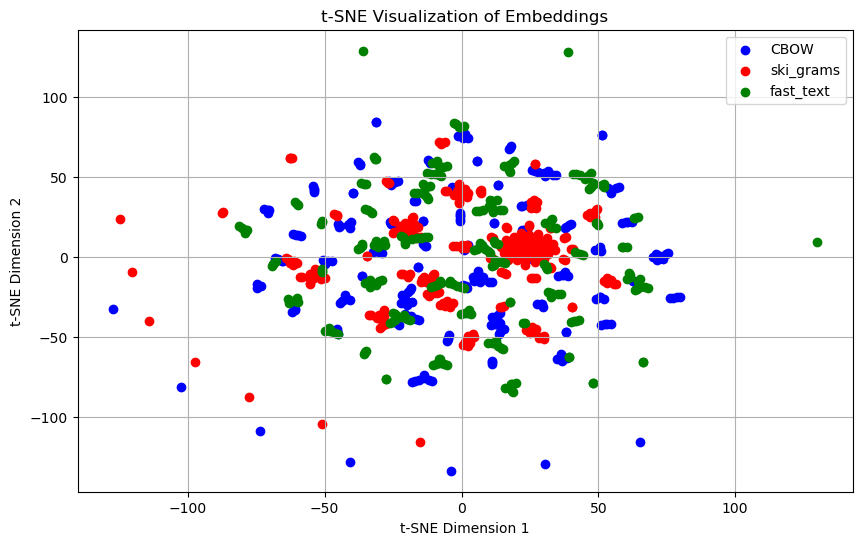

In [40]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Provided embeddings
emb1 = embeddings_cbow
emb2 = ski_grams
emb3 = fast_text_embeding

# Initialize t-SNE models
tsne_emb1 = TSNE(n_components=2, learning_rate='auto', init='random', random_state=42, perplexity=1)
tsne_emb2 = TSNE(n_components=2, learning_rate='auto', init='random', random_state=42, perplexity=1)
tsne_emb3 = TSNE(n_components=2, learning_rate='auto', init='random', random_state=42, perplexity=1)

# Fit and transform embeddings using t-SNE
embeddings_2d_emb1 = tsne_emb1.fit_transform(emb1)
embeddings_2d_emb2 = tsne_emb2.fit_transform(emb2)
embeddings_2d_emb3 = tsne_emb3.fit_transform(emb3)

# Plot the 2D embeddings
plt.figure(figsize=(10, 6))

# Plot emb1
plt.scatter(embeddings_2d_emb1[:, 0], embeddings_2d_emb1[:, 1], color='blue', label='CBOW')

# Plot emb2
plt.scatter(embeddings_2d_emb2[:, 0], embeddings_2d_emb2[:, 1], color='red', label='ski_grams')

# Plot emb3
plt.scatter(embeddings_2d_emb3[:, 0], embeddings_2d_emb3[:, 1], color='green', label='fast_text')

plt.title("t-SNE Visualization of Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.grid(True)
plt.show()


## Conclusion 

Upon visualizing the embeddings of vocabulary derived from different models, such as FastText CBOW and skip-grams, using the t-distributed stochastic neighbor embedding (t-SNE) algorithm, it becomes evident that the resulting visualizations portray a striking similarity. Despite the variance in training methodologies—CBOW focusing on predicting the target word from its context, while skip-gram predicts the context from the target word—the clusters formed in the visualizations exhibit a notable resemblance. This alignment suggests that both models effectively capture semantic relationships within the vocabulary, as evidenced by the cohesive groupings of semantically related words. While slight discrepancies in cluster positioning may be observed, the overarching structure and inter-word associations remain consistent across the embeddings produced by the different models.